In [1]:
# setting up 
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# set style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# connecting to database
conn = duckdb.connect('../data/processed/spotify.duckdb')

print("Final Analysis - The Perfect Workout Playlist")

# basic stats
stats = {
    'tracks': conn.execute("SELECT COUNT(*) FROM tracks").fetchone()[0],
    'playlists': conn.execute("SELECT COUNT(DISTINCT playlist_id) FROM playlists").fetchone()[0],
    'entries': conn.execute("SELECT COUNT(*) FROM playlist_tracks").fetchone()[0],
    'artists': conn.execute("SELECT COUNT(DISTINCT artist_name) FROM tracks").fetchone()[0]
}

print(f"\nDataset Overview:")
print(f"   • Total Records: {stats['entries']:,}")
print(f"   • Unique Tracks: {stats['tracks']:,}")
print(f"   • Playlists: {stats['playlists']:,}")
print(f"   • Unique Artists: {stats['artists']:,}")

Final Analysis - The Perfect Workout Playlist

Dataset Overview:
   • Total Records: 155,370
   • Unique Tracks: 30,211
   • Playlists: 983
   • Unique Artists: 7,517


Top Artists in Workout Music
      artist_name  playlist_appearances  unique_tracks  popularity
0    David Guetta                   208            101        68.1
1           Drake                   170            163        68.4
2      Kanye West                   166            100        63.0
3          Tiësto                   159             87        60.4
4   Calvin Harris                   154             63        70.8
5          Eminem                   152             93        68.8
6         Rihanna                   149             88        71.6
7  Kendrick Lamar                   127             67        73.7
8       Lady Gaga                   117             85        66.6
9      The Weeknd                   114             60        68.9


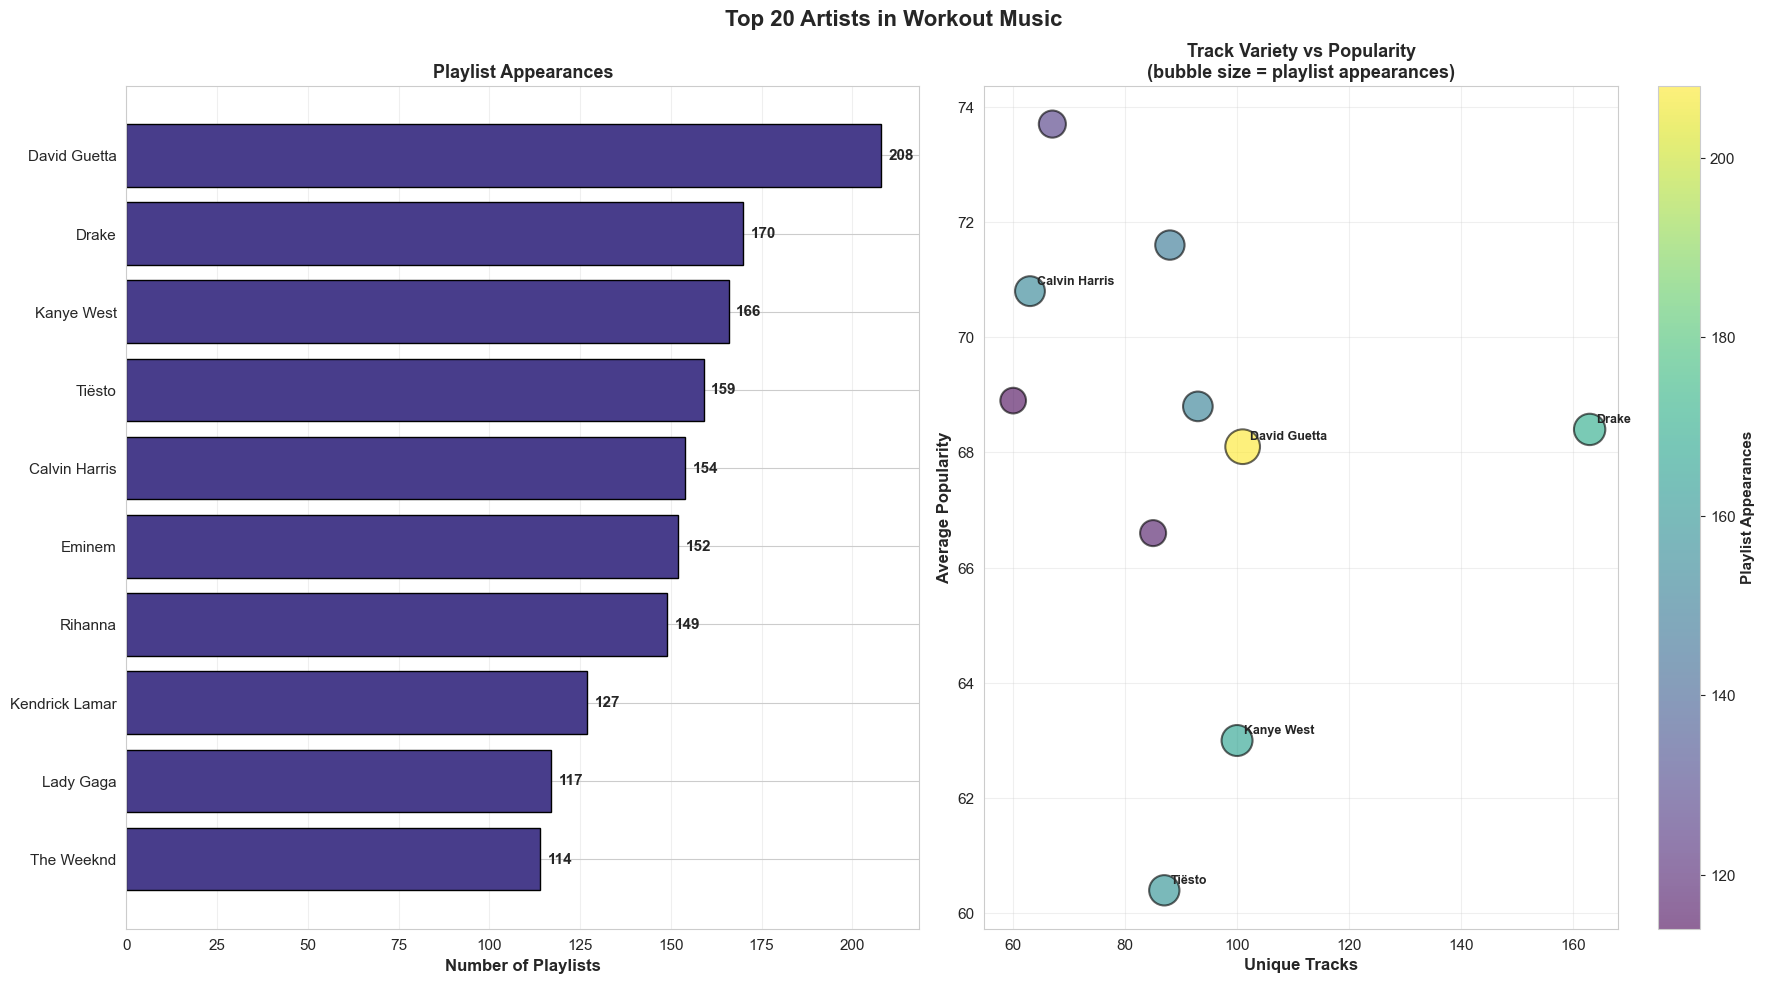


Saved as: top_artists.png


In [5]:
# Top Artists Visualization
print("Top Artists in Workout Music")

df_artists = conn.execute("""
    SELECT artist_name, playlist_appearances, unique_tracks, 
           ROUND(avg_popularity, 1) as popularity
    FROM v_top_artists 
    LIMIT 10
""").df()

print(df_artists)

# create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Top 20 Artists in Workout Music', fontsize=16, fontweight='bold')

# playlist appearances (bar chart)
ax1 = axes[0]
y_pos = np.arange(len(df_artists))
bars = ax1.barh(y_pos, df_artists['playlist_appearances'], color='darkslateblue', edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(df_artists['artist_name'])
ax1.invert_yaxis()
ax1.set_xlabel('Number of Playlists', fontweight='bold', fontsize=12)
ax1.set_title('Playlist Appearances', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for i, v in enumerate(df_artists['playlist_appearances']):
    ax1.text(v + 2, i, str(v), va='center', fontweight='bold')

# unique tracks vs popularity (bubble chart)
ax2 = axes[1]
scatter = ax2.scatter(df_artists['unique_tracks'], 
                     df_artists['popularity'],
                     s=df_artists['playlist_appearances']*3,
                     c=df_artists['playlist_appearances'],
                     cmap='viridis',
                     alpha=0.6,
                     edgecolors='black',
                     linewidths=1.5)

ax2.set_xlabel('Unique Tracks', fontweight='bold', fontsize=12)
ax2.set_ylabel('Average Popularity', fontweight='bold', fontsize=12)
ax2.set_title('Track Variety vs Popularity\n(bubble size = playlist appearances)', 
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# color bar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Playlist Appearances', fontweight='bold')

# showing top 5 artists
for idx in range(min(5, len(df_artists))):
    ax2.annotate(df_artists.iloc[idx]['artist_name'], 
                xy=(df_artists.iloc[idx]['unique_tracks'], df_artists.iloc[idx]['popularity']),
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/analytics/top_artists.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved as: top_artists.png")

In [8]:
# close
conn.close()

print("Analysis Complete!")

Analysis Complete!
